# Azure Machine Learning End-To-End Functional Overview using CLI for MLOPS

Microsoft Azure Machine Learning platform supports seamless, end-to-end AI/ML lifecycle management workflows: 

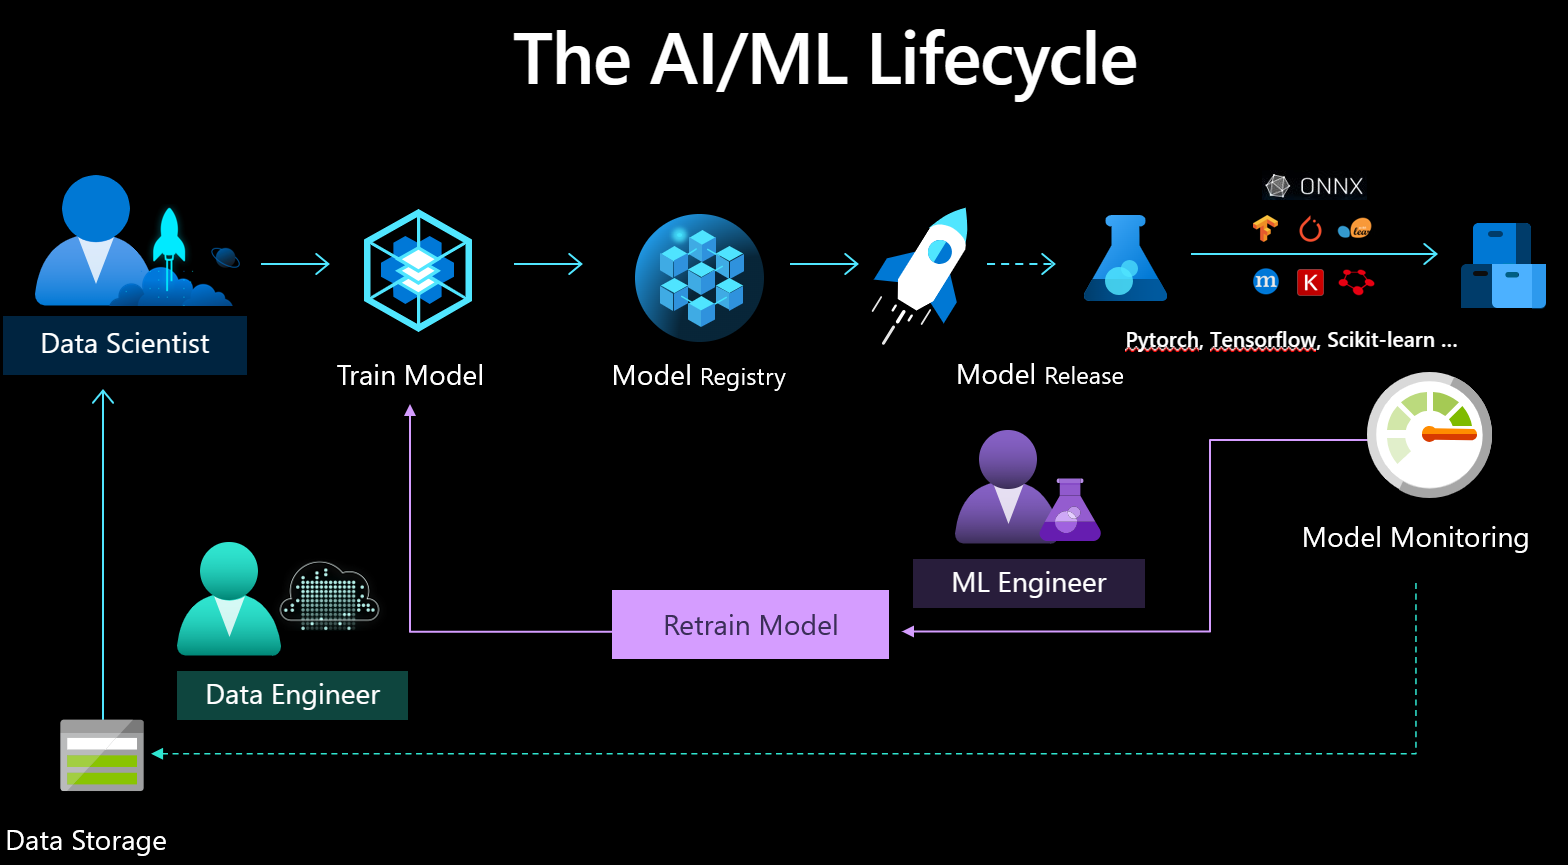

Azure ML offers tooling to support real-world enterprise lifecycle which includes:
1. Proof of Concept experimentation
2. Scaled training pipelines
3. Production-ready endpoint management

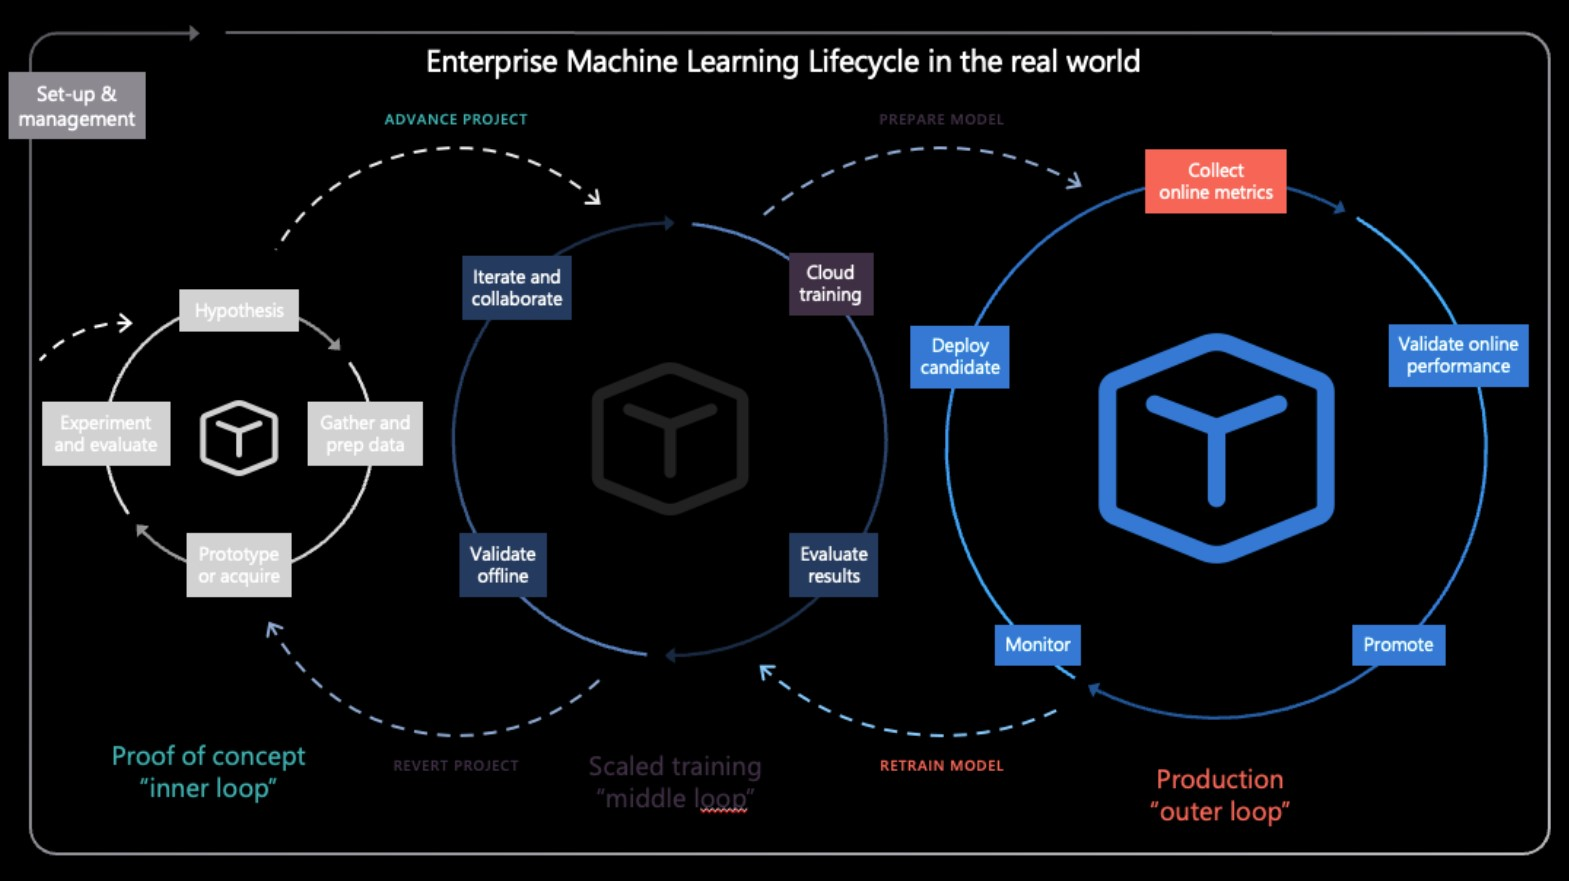

Conceptually, Azure ML Platform encapsulates access to platform resources as Machine Learning Workspaces.  These workspaces provide access to various platform resources, such as:
- HPC computing hardware
- Scalable Data assets
- MLOps pipeline configurations and metrics
- Model evaluation resources

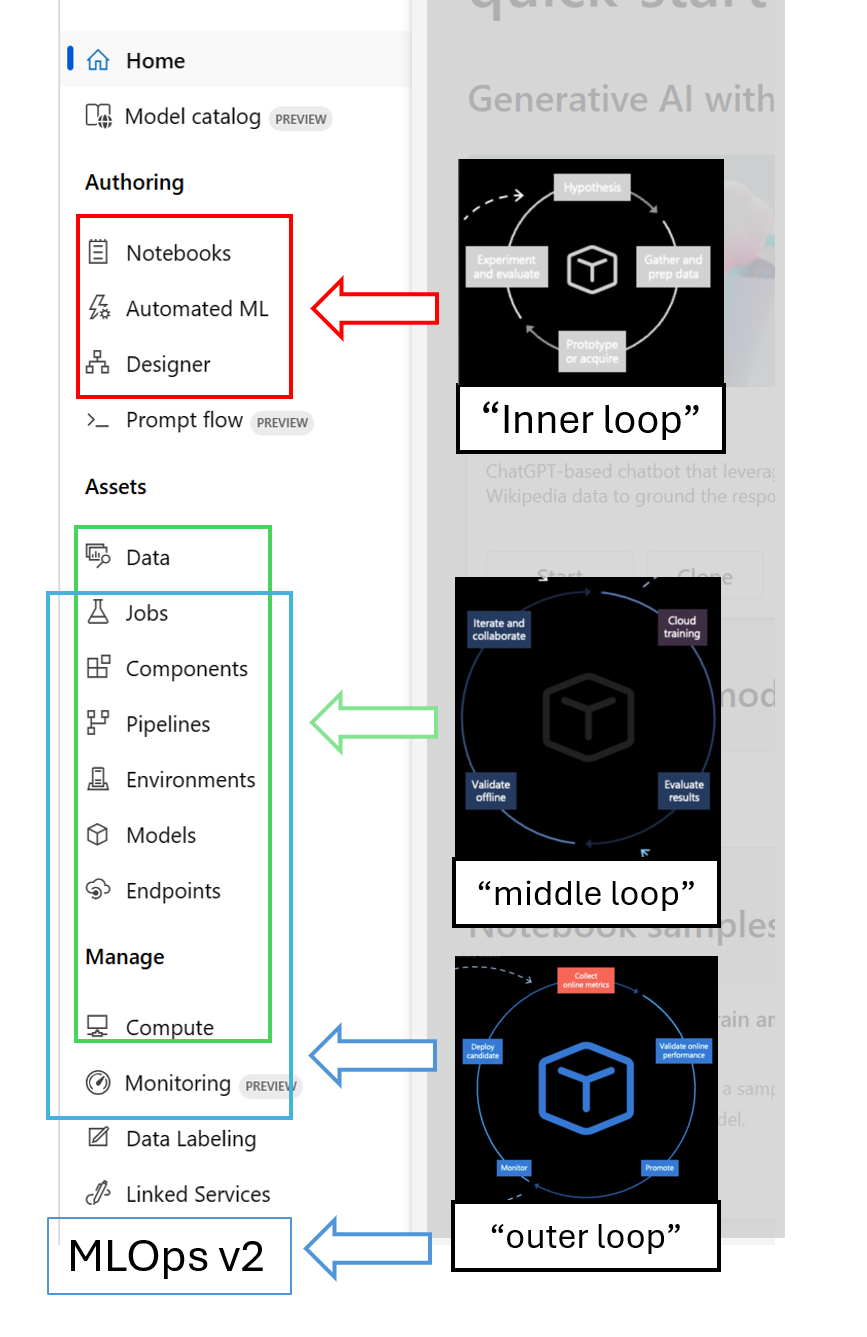

This tutorial outlines the following platform capabilities:
1. End-to-end Solution Proof of Concept (PoC)
2. AI-enabled support tools (GitHub Copilot)
3. Function-specific off-the-shelf components
4. MLOps Support Options
5. Administration and Security features

The various capabilities available as part of the Azure Machine Learning Workspaces may be accessed using:
- Web interface
- Python SDK
- CLI command line tools

Python SDK:
<a href="https://learn.microsoft.com/en-us/python/api/overview/azure/ml/?view=azure-ml-py">Python SDK Documentation</a>

CLI command line tools:
<a href="https://learn.microsoft.com/en-us/cli/azure/ml?view=azure-cli-latest">CLI Documentation</a>

## 1. End-to-End Solution Proof of Concept (PoC)

Use Case: Predict likelihood of credit default using customer credit card payment records

This section shows how to:

- Step 0: Authenticate with Azure Machine Learning Platform using CLI
- Step 1: Import a Data assets into the Azure ML Workspace using CLI
- Step 2: Access Data assets using Jupyter Notebooks
- Step 3: Create and deploy a scalable computing resource
- Step 4: Train a Machine Learning model using Data assets and scalable computing resources
- Step 5: Register model with Azure ML Workspace Model Registry
- Step 6: Create a scalable, managed online Endpoint
- Step 7: Deploy registered model to a production-ready online Endpoint

### Step 0: Authenticate with Azure Machine Learning Platform using CLI

##### Configure Azure ML session

#### ********Login to Azure if you are NOT running on AML Compute Instance!!!

It is now necessary to configure local Azure ML session to point to the appropriate workspace and resource group.  The following code configures local CLI environment for subsequent use.

In [1]:
!az login

To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FD4DCZ3D6 to authenticate.
[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "074101a8-2a55-4e54-9b9f-56c83e17cb22",
    "id": "f1ea6ed8-82f3-416d-881b-8b376218bc85",
    "isDefault": true,
    "managedByTenants": [
      {
        "tenantId": "72f988bf-86f1-41af-91ab-2d7cd011db47"
      },
      {
        "tenantId": "2f4a9838-26b7-47ee-be60-ccc1fdec5953"
      }
    ],
    "name": "gbb-alzeltov",
    "state": "Enabled",
    "tenantId": "074101a8-2a55-4e54-9b9f-56c83e17cb22",
    "user": {
      "name": "alex@azlabs49.net",
      "type": "user"
    }
  },
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "66383b3b-cd3a-4370-a998-23f37a361462",
    "id": "9c3ad382-b1a0-4836-a23e-b500003ef7ab",
    "isDefault": false,
    "managedByTenants": [
      {
        "tenantId": "72f988bf-86f1-41af-91ab-2d7cd011db47"
      }
    ],
    "name": "Azure Retail Lab - MngEnv484644 - Subscr

###### Configure session parameters

Authentication information is available in the Azure ML Workspace

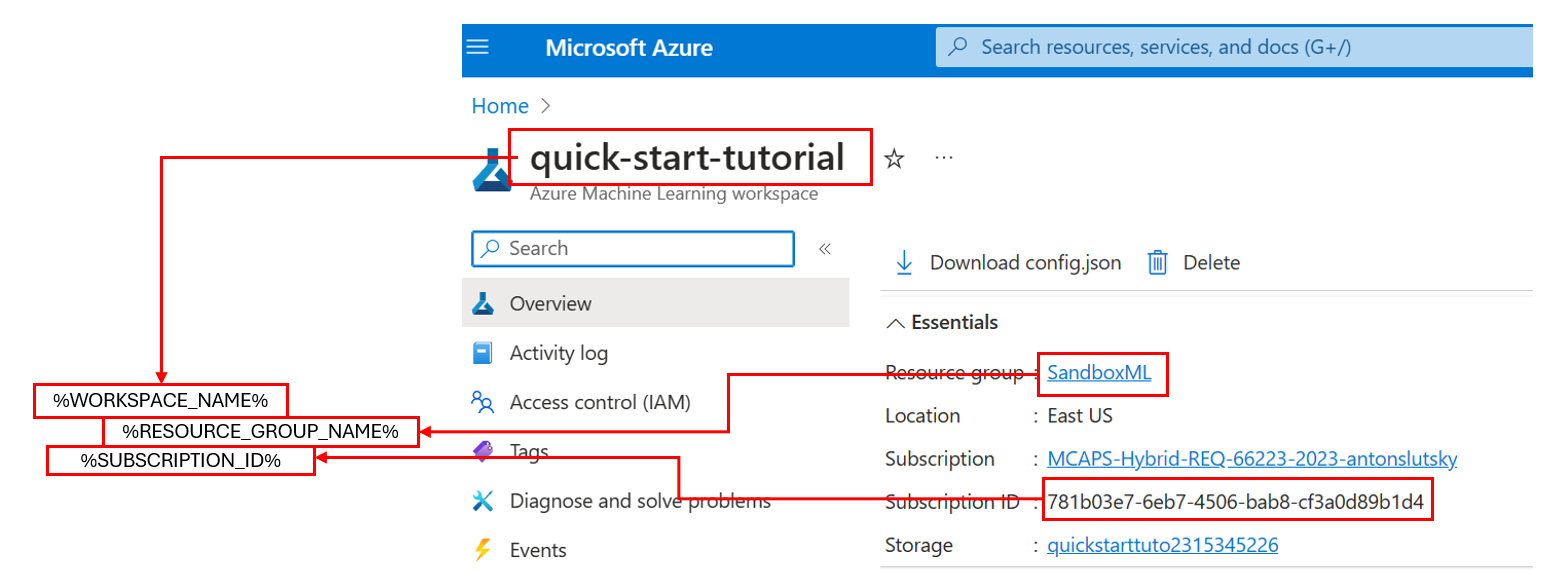

##### You might need to install or upgrade your az ml extension

In [3]:
!az extension add -n ml

### Step 1: Import a Data assets into the Azure ML Workspace using CLI

Import local data into the Azure ML Platform workspace

In [4]:
%%writefile dataimport.yml
$schema: https://azuremlschemas.azureedge.net/latest/data.schema.json
name: credit_cards
description: Data asset created from local file.
type: uri_file
path: data/default_of_credit_card_clients.csv

Overwriting dataimport.yml


In [5]:
!az ml data create --file dataimport.yml 

{
  "creation_context": {
    "created_at": "2023-10-25T02:45:34.988353+00:00",
    "created_by": "alex zeltov",
    "created_by_type": "User",
    "last_modified_at": "2023-10-25T02:45:35.009952+00:00"
  },
  "description": "Data asset created from local file.",
  "id": "/subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/resourceGroups/rg_aml/providers/Microsoft.MachineLearningServices/workspaces/aml-default/data/credit_cards/versions/2",
  "name": "credit_cards",
  "path": "azureml://subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourcegroups/SandboxML/workspaces/quick-start-tutorial/datastores/workspaceblobstore/paths/LocalUpload/4b1dfc4d12429b46389cabdf25b886a2/default_of_credit_card_clients.csv",
  "properties": {},
  "resourceGroup": "SandboxML",
  "tags": {},
  "type": "uri_file",
  "version": "2"
}


You can see the uploaded data by selecting **Data** on the left. You'll see the data is uploaded and a data asset is created:

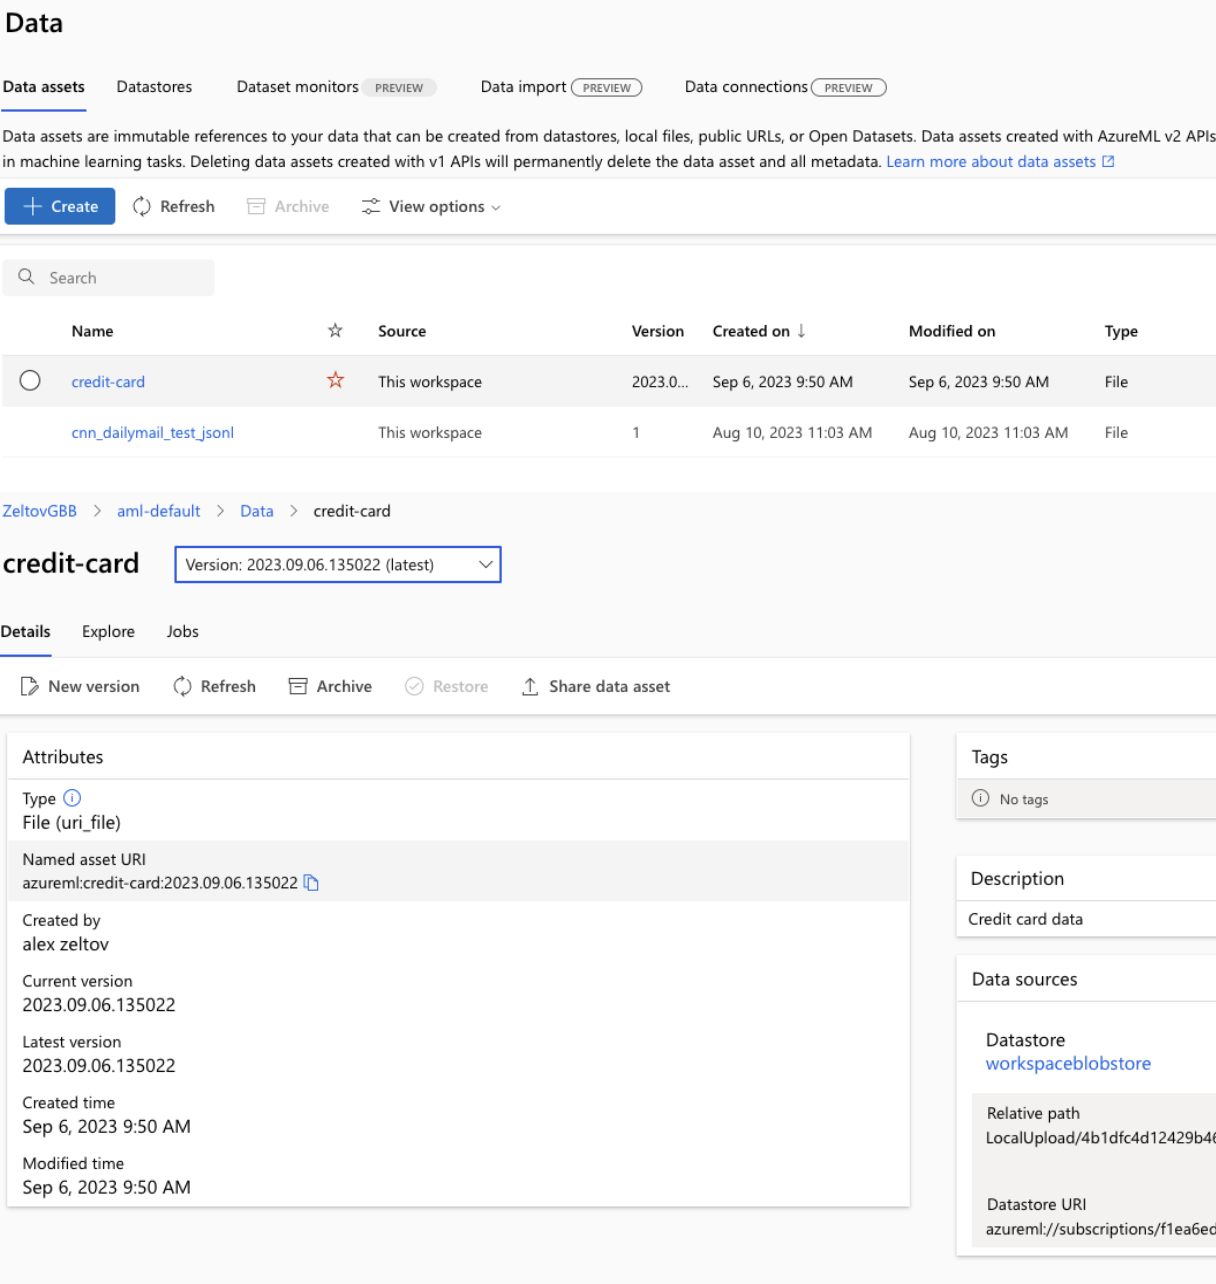

This data is named **credit-card**, and in the **Data assets** tab, we can see it in the **Name** column. This data uploaded to your workspace's default datastore named **workspaceblobstore**, seen in the **Data source** column. 

An Azure Machine Learning datastore is a *reference* to an *existing* storage account on Azure. A datastore offers these benefits:

1. A common and easy-to-use API, to interact with different storage types (Blob/Files/Azure Data Lake Storage) and authentication methods.
1. An easier way to discover useful datastores, when working as a team.
1. In your scripts, a way to hide connection information for credential-based data access (service principal/SAS/key).




### Step 2: Access Data assets using Jupyter Notebooks

Pandas directly support URIs - this example shows how to read a CSV file from an Azure Machine Learning Datastore:

```
import pandas as pd

df = pd.read_csv("azureml://subscriptions/<subid>/resourcegroups/<rgname>/workspaces/<workspace_name>/datastores/<datastore_name>/paths/<folder>/<filename>.csv")
```

### Step 3: Create and deploy a scalable computing resource

Example of a scalable cluster configuration

In [6]:
!az ml compute create -n cpu-cluster-test --type amlcompute \
    --min-instances 0 \
    --max-instances 4 \
    --size STANDARD_DS3_V2 \
    --idle-time-before-scale-down 180 \
    --tier Dedicated 

env: CLUSTER_NAME=cpu-cluster-test
{\ Finished ..
  "enable_node_public_ip": true,
  "id": "/subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/resourceGroups/rg_aml/providers/Microsoft.MachineLearningServices/workspaces/aml-default/computes/cpu-cluster-test",
  "idle_time_before_scale_down": 180,
  "location": "eastus",
  "max_instances": 4,
  "min_instances": 0,
  "name": "cpu-cluster-test",
  "network_settings": {},
  "provisioning_state": "Succeeded",
  "resourceGroup": "rg_aml",
  "size": "STANDARD_DS3_V2",
  "ssh_public_access_enabled": true,
  "tier": "dedicated",
  "type": "amlcompute"
}


### Step 4: Train a Machine Learning model using Data assets and scalable computing resources

In [8]:
%%writefile dependencies/credit_train_cli_env.yml
$schema: https://azuremlschemas.azureedge.net/latest/environment.schema.json
name: credit_train_cli_env
image: mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest
conda_file: conda.yml
description: Environment created from a Docker image plus Conda environment.


Overwriting dependencies/credit_train_cli_env.yml


In [10]:
!az ml environment create --name credit_train_cli_env --version 1 --file dependencies/credit_train_cli_env.yml

{
  "conda_file": {
    "channels": [
      "conda-forge"
    ],
    "dependencies": [
      "python=3.8",
      "numpy=1.21.2",
      "pip=21.2.4",
      "scikit-learn=0.24.2",
      "scipy=1.7.1",
      "pandas>=1.1,<1.2",
      {
        "pip": [
          "inference-schema[numpy-support]==1.3.0",
          "azureml-mlflow==1.42.0",
          "psutil>=5.8,<5.9",
          "tqdm>=4.59,<4.60",
          "ipykernel~=6.0",
          "matplotlib",
          "pyarrow"
        ]
      }
    ],
    "name": "model-env"
  },
  "creation_context": {
    "created_at": "2023-10-25T02:51:50.558411+00:00",
    "created_by": "alex zeltov",
    "created_by_type": "User",
    "last_modified_at": "2023-10-25T02:51:50.558411+00:00",
    "last_modified_by": "alex zeltov",
    "last_modified_by_type": "User"
  },
  "description": "Environment created from a Docker image plus Conda environment.",
  "id": "azureml:/subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/resourceGroups/rg_aml/providers/Microsoft

#### Create Job configuration

Now create a job configuration file that references the <a href="./dependencies/conda.yml">conda.yml</a> to create a job and initialize execution.

In [11]:
%%writefile dependencies/cli_job.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandJob.schema.json
code: ../src
command: >-
  python main.py 
  --data ${{inputs.data}} 
  --test_train_ratio ${{inputs.test_train_ratio}}               
  --learning_rate ${{inputs.learning_rate}}                    
  --registered_model_name ${{inputs.registered_model_name}}
inputs:
  data: 
    type: uri_file
    path: azureml:credit_cards:3
  test_train_ratio: 0.2
  learning_rate: 0.25
  registered_model_name: credit_default_model
environment: 
  image: mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest
  conda_file: conda.yml 
compute: azureml:cpu-cluster-test
display_name: Credit Card Demo 3
experiment_name: credit-card-demo-experiment-3
description: Train a model on credit card dataset

Overwriting dependencies/cli_job.yml


#### Submit the Job configuration for processing

In [55]:
!az ml job create -f dependencies/cli_job.yml --query name -o tsv

gentle_tongue_lfy5vqjk99


Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


#### Verify Job Status

Observe the job configuration and runtime information is now available in the Jobs user interface section of the platform workspace:

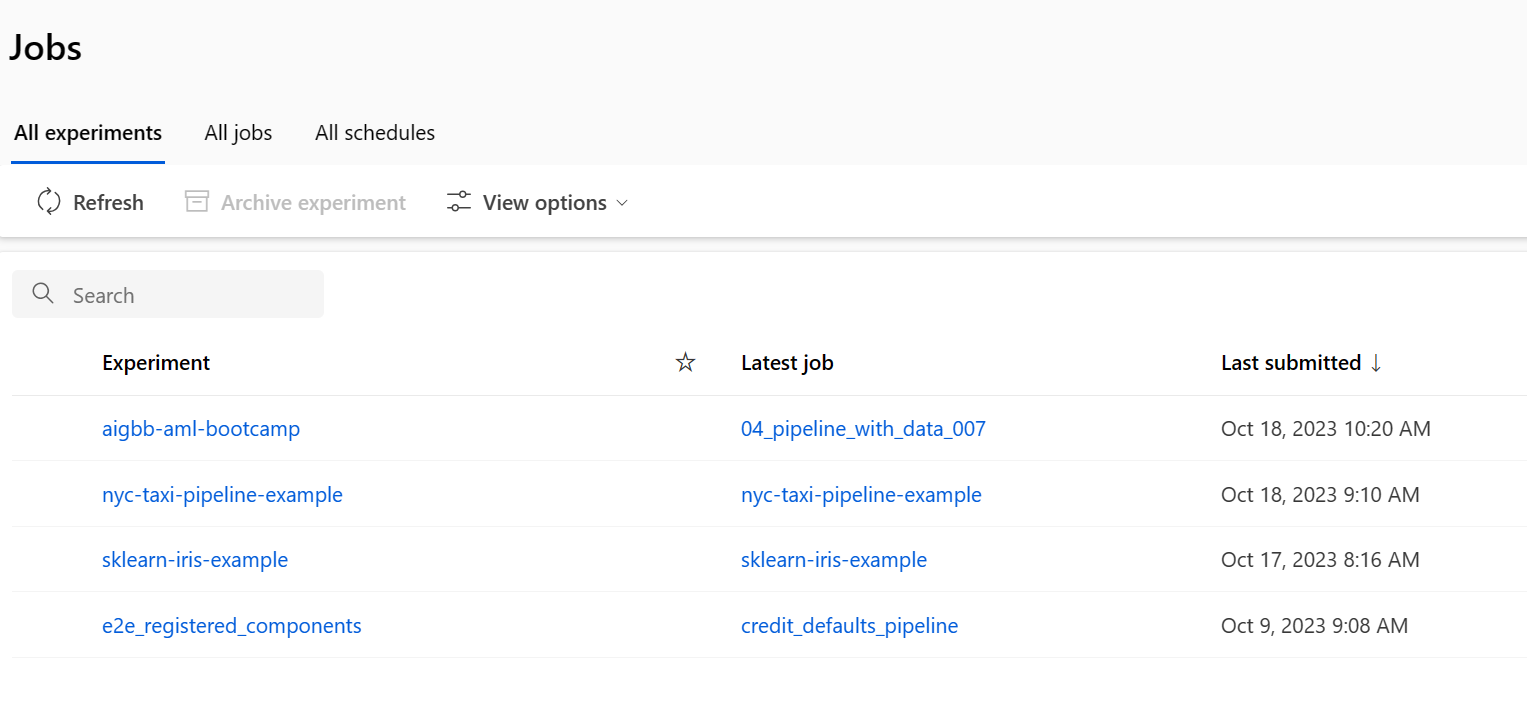

#### View job output and wait for job completion

View the job in Azure Machine Learning studio by selecting the link in the output of the previous cell. The output of this job will look like this in the Azure Machine Learning studio. Explore the tabs for various details like metrics, outputs etc. Once completed, the job will register a model in your workspace as a result of training. 

![Screenshot shows the overview page for the job.](./media/view-job.gif)

> [!IMPORTANT]
> Wait until the status of the job is complete before returning to this notebook to continue. The job will take 2 to 3 minutes to run. It could take longer (up to 10 minutes) if the compute cluster has been scaled down to zero nodes and custom environment is still building.

When you run the cell, the notebook output shows a link to the job's details page on Azure Studio. Alternatively, you can also select Jobs on the left navigation menu. A job is a grouping of many runs from a specified script or piece of code. Information for the run is stored under that job. The details page gives an overview of the job, the time it took to run, when it was created, etc. The page also has tabs to other information about the job such as metrics, Outputs + logs, and code. Listed below are the tabs available in the job's details page:

* Overview: The overview section provides basic information about the job, including its status, start and end times, and the type of job that was run
* Inputs: The input section lists the data and code that were used as inputs for the job. This section can include datasets, scripts, environment configurations, and other resources that were used during training. 
* Outputs + logs: The Outputs + logs tab contains logs generated while the job was running. This tab assists in troubleshooting if anything goes wrong with your training script or model creation.
* Metrics: The metrics tab showcases key performance metrics from your model such as training score, f1 score, and precision score. 

### Step 5: Register a local model with Azure ML Workspace Model Registry


#### Register the model

If you already completed the earlier training tutorial,  [Train a model](https://learn.microsoft.com/en-us/azure/machine-learning/tutorial-train-model), you've registered an MLflow model as part of the training script and can skip to the next section. 

If you didn't complete the training tutorial, you'll need to register the model. Registering your model before deployment is a recommended best practice.

In this example, we specify the `path` (where to upload files from) inline. If you [cloned the tutorials folder](https://learn.microsoft.com/en-us/azure/machine-learning/quickstart-create-resources##learn-from-sample-notebooks), then run the following code as-is. Otherwise, [download the files and metadata for the model to deploy](https://azuremlexampledata.blob.core.windows.net/datasets/credit_defaults_model.zip). Update the path to the location on your local computer where you've unzipped the model's files. 

The SDK automatically uploads the files and registers the model. 

For more information on registering your model as an asset, see [Register your model as an asset in Machine Learning by using the SDK](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-models?tabs=use-local%2Ccli#register-your-model-as-an-asset-in-machine-learning-by-using-the-sdk).

Deploy a local model to an endpoint:

In [13]:
%%writefile register_model.yml
$schema: https://azuremlschemas.azureedge.net/latest/model.schema.json
name: credit_defaults_model
path: ./deploy/credit_defaults_model/
type: mlflow_model
description: Credit Defaults Model.

Overwriting register_model.yml


In [49]:
!az ml model create -f register_model.yml

{
  "creation_context": {
    "created_at": "2023-10-24T18:59:53.783255+00:00",
    "created_by": "Anton Slutsky",
    "created_by_type": "User",
    "last_modified_at": "2023-10-24T18:59:53.783255+00:00",
    "last_modified_by": "Anton Slutsky",
    "last_modified_by_type": "User"
  },
  "description": "Credit Defaults Model.",
  "flavors": {
    "python_function": {
      "env": "{\n  \"conda\": \"conda.yaml\",\n  \"virtualenv\": \"python_env.yaml\"\n}",
      "loader_module": "mlflow.sklearn",
      "model_path": "model.pkl",
      "predict_fn": "predict",
      "python_version": "3.8.18"
    },
    "sklearn": {
      "code": "",
      "pickled_model": "model.pkl",
      "serialization_format": "cloudpickle",
      "sklearn_version": "0.24.2"
    }
  },
  "id": "azureml:/subscriptions/781b03e7-6eb7-4506-bab8-cf3a0d89b1d4/resourceGroups/SandboxML/providers/Microsoft.MachineLearningServices/workspaces/quick-start-tutorial/models/credit_defaults_model/versions/21",
  "name": "credit_de

### NOTE: Centralized ML Regstry, key component of MLOps

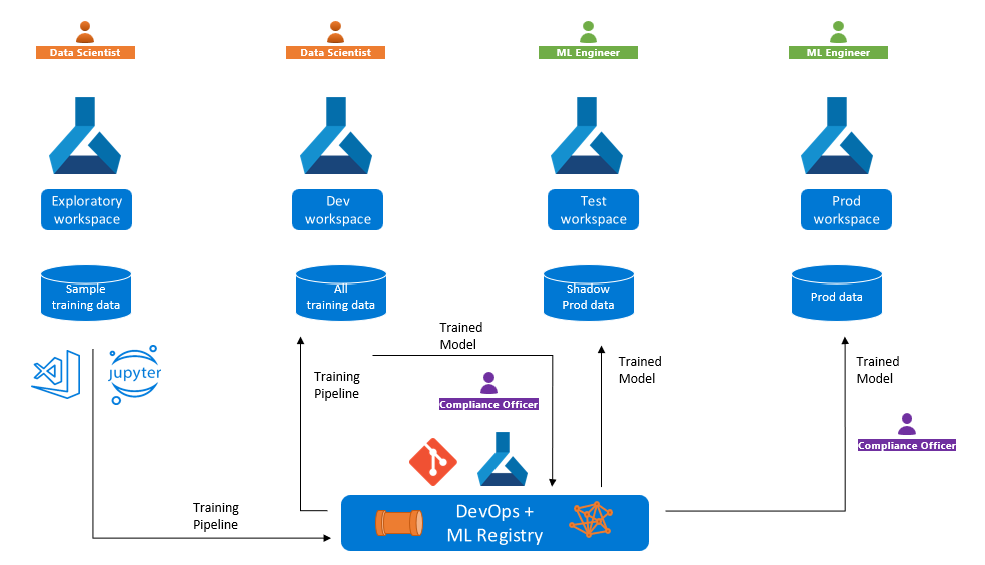

#### Verify Model Registration using Web UI

Trained models are managed through a Model Registry

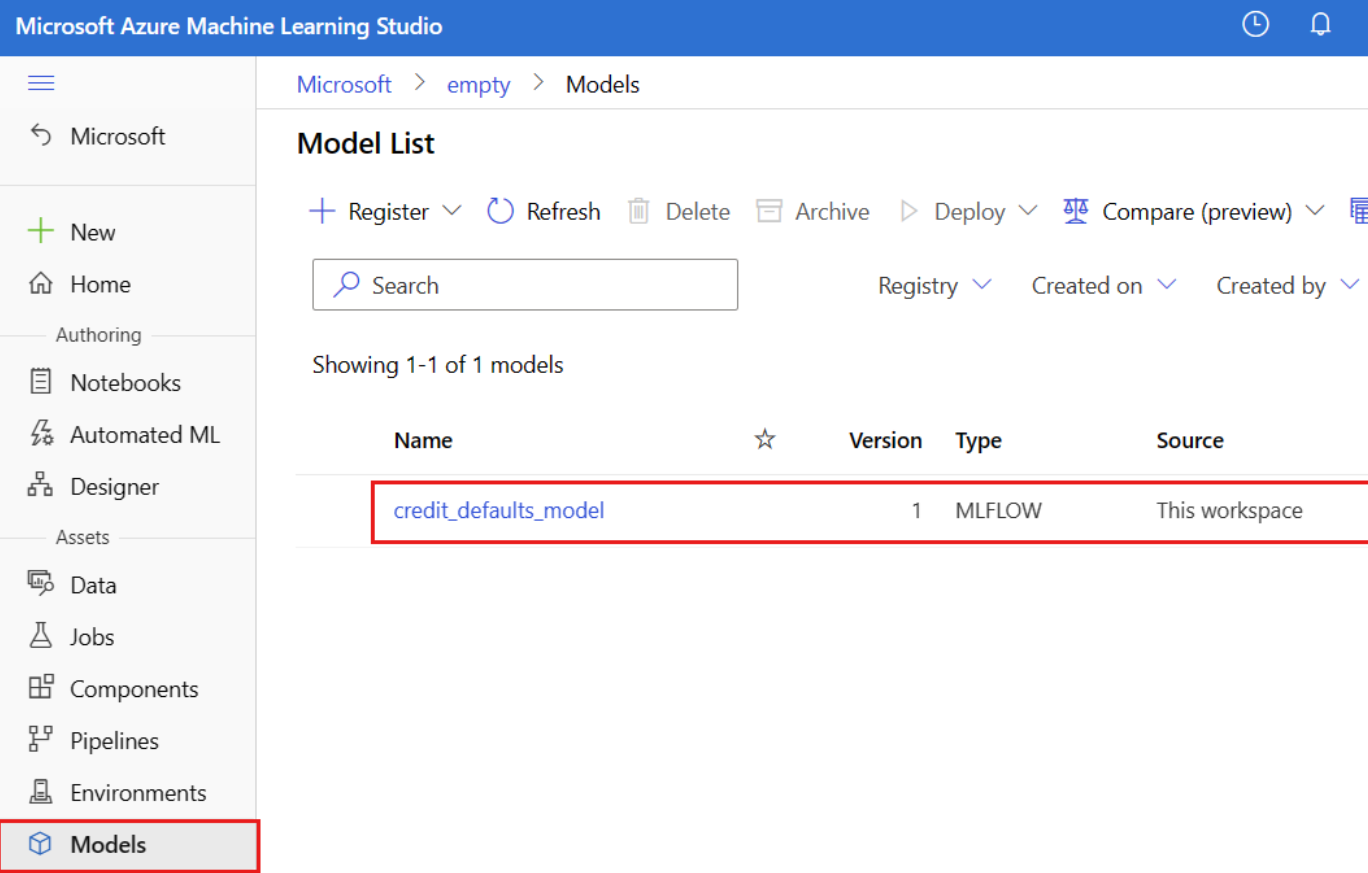

### Step 6: Create a scalable, managed online Endpoint

#### Understanding online Endpoints

After you train a machine learning model, you need to deploy it so that others can use it for inferencing. For this purpose, Azure Machine Learning allows you to create **endpoints** and add **deployments** to them.

An **endpoint**, in this context, is an HTTPS path that provides an interface for clients to send requests (input data) to a trained model and receive the inferencing (scoring) results back from the model. An endpoint provides:

- Authentication using "key or token" based auth 
- [TLS(SSL)](https://simple.wikipedia.org/wiki/Transport_Layer_Security) termination
- A stable scoring URI (endpoint-name.region.inference.ml.azure.com)


A **deployment** is a set of resources required for hosting the model that does the actual inferencing. 

A single endpoint can contain multiple deployments. Endpoints and deployments are independent Azure Resource Manager resources that appear in the Azure portal.

Azure Machine Learning allows you to implement [online endpoints](https://learn.microsoft.com/en-us/azure/machine-learning/concept-endpoints#what-are-online-endpoints) for real-time inferencing on client data, and [batch endpoints](https://learn.microsoft.com/en-us/azure/machine-learning/concept-endpoints#what-are-batch-endpoints) for inferencing on large volumes of data over a period of time. 

In this tutorial, we'll walk you through the steps of implementing a _managed online endpoint_. Managed online endpoints work with powerful CPU and GPU machines in Azure in a scalable, fully managed way that frees you from the overhead of setting up and managing the underlying deployment infrastructure.

#### Create an online endpoint

Now that you have a registered model, it's time to create your online endpoint. The endpoint name needs to be unique in the entire Azure region. For this tutorial, you'll create a unique name using a universally unique identifier [`UUID`](https://en.wikipedia.org/wiki/Universally_unique_identifier). For more information on the endpoint naming rules, see [managed online endpoint limits](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-quotas#azure-machine-learning-managed-online-endpoints).

In [1]:
%%writefile endpoint.yml
$schema: https://azuremlschemas.azureedge.net/latest/managedOnlineEndpoint.schema.json
name: e-2-ecredit-endpoint-1
auth_mode: key
tags:
    training_dataset : credit_defaults

Writing endpoint.yml


First, we'll define the endpoint, using the `ManagedOnlineEndpoint` class.



> [!TIP]
> * `auth_mode` : Use `key` for key-based authentication. Use `aml_token` for Azure Machine Learning token-based authentication. A `key` doesn't expire, but `aml_token` does expire. For more information on authenticating, see [Authenticate to an online endpoint](https://learn.microsoft.com/azure/machine-learning/how-to-authenticate-online-endpoint).
> * Optionally, you can add a description and tags to your endpoint.

In [1]:
!az ml online-endpoint create --file endpoint.yml

{| Finished ..
  "auth_mode": "key",
  "id": "/subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/resourceGroups/rg_aml/providers/Microsoft.MachineLearningServices/workspaces/aml-default/onlineEndpoints/e-2-ecredit-endpoint-1",
  "identity": {
    "principal_id": "872b5aab-f9fc-402d-951f-e01f71eb92fd",
    "tenant_id": "074101a8-2a55-4e54-9b9f-56c83e17cb22",
    "type": "system_assigned"
  },
  "kind": "Managed",
  "location": "eastus",
  "mirror_traffic": {},
  "name": "e-2-ecredit-endpoint-1",
  "openapi_uri": "https://e-2-ecredit-endpoint-1.eastus.inference.ml.azure.com/swagger.json",
  "properties": {
    "AzureAsyncOperationUri": "https://management.azure.com/subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oe:b8b691ba-fd02-471a-9ad5-ffc195254a8e:10ff0134-51fd-4a6c-9fd7-4bc7ba4a1a3a?api-version=2022-02-01-preview",
    "azureml.onlineendpointid": "/subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/

Using the `MLClient` created earlier, we'll now create the endpoint in the workspace. This command will start the endpoint creation and return a confirmation response while the endpoint creation continues.

> [!NOTE]
> Expect the endpoint creation to take approximately 2 minutes.

### Step 7: Deploy registered model to a production-ready online Endpoint

#### Understanding online deployments

The key aspects of a deployment include:

- `name` - Name of the deployment.
- `endpoint_name` - Name of the endpoint that will contain the deployment.
- `model` - The model to use for the deployment. This value can be either a reference to an existing versioned model in the workspace or an inline model specification.
- `environment` - The environment to use for the deployment (or to run the model). This value can be either a reference to an existing versioned environment in the workspace or an inline environment specification. The environment can be a Docker image with Conda dependencies or a Dockerfile.
- `code_configuration` - the configuration for the source code and scoring script.
    - `path`- Path to the source code directory for scoring the model.
    - `scoring_script` - Relative path to the scoring file in the source code directory. This script executes the model on a given input request. For an example of a scoring script, see [Understand the scoring script](https://learn.microsoft.com/azure/machine-learning/how-to-deploy-online-endpoints#understand-the-scoring-script) in the "Deploy an ML model with an online endpoint" article.
- `instance_type` - The VM size to use for the deployment. For the list of supported sizes, see [Managed online endpoints SKU list](https://learn.microsoft.com/azure/machine-learning/reference-managed-online-endpoints-vm-sku-list).
- `instance_count` - The number of instances to use for the deployment.
    
#### Understanding MLflow model deployment

Azure Machine Learning supports no-code deployment of a model created and logged with MLflow. This means that you don't have to provide a scoring script or an environment during model deployment, as the scoring script and environment are automatically generated when training an MLflow model. If you were using a custom model, though, you'd have to specify the environment and scoring script during deployment.

> [!IMPORTANT]
> If you typically deploy models using scoring scripts and custom environments and want to achieve the same functionality using MLflow models, we recommend reading [Using MLflow models for no-code deployment](https://learn.microsoft.com/azure/machine-learning/how-to-deploy-mlflow-models).

#### Deploy the model to the endpoint

You'll begin by creating a single deployment that handles 100% of the incoming traffic. We've chosen an arbitrary color name (*blue*) for the deployment. To create the deployment for our endpoint, we'll use the `ManagedOnlineDeployment` class.

> [!NOTE]
> No need to specify an environment or scoring script as the model to deploy is an MLflow model.

In [ ]:
!az ml model download --name credit_defaults_model --version 11 --download-path .

In [60]:
!az ml model download --name credit_defaults_model --version 1 --download-path .

In [15]:
%%writefile dependencies/endpoint.yml
$schema: https://azuremlschemas.azureedge.net/latest/environment.schema.json
name: demo-e2e-inference-env
image: mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest
conda_file: conda-inference.yml
description: Environment created from a Docker image plus Conda environment.

Overwriting dependencies/endpoint.yml


In [18]:
%%writefile dependencies/conda-inference.yml
name: model-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - numpy=1.21.2
  - pip=21.2.4
  - scikit-learn=0.24.2
  - scipy=1.7.1
  - pandas>=1.1,<1.2
  - pip:
    - inference-schema[numpy-support]==1.3.0
    - joblib==1.3.2
    - azureml-mlflow==1.42.0
    - psutil>=5.8,<5.9
    - tqdm>=4.59,<4.60
    - pyarrow
    - azureml-inference-server-http


Writing dependencies/conda-inference.yml


In [20]:
!az ml environment create --name demo-e2e-inference-env  --file dependencies/endpoint.yml 

{
  "conda_file": {
    "channels": [
      "conda-forge"
    ],
    "dependencies": [
      "python=3.8",
      "numpy=1.21.2",
      "pip=21.2.4",
      "scikit-learn=0.24.2",
      "scipy=1.7.1",
      "pandas>=1.1,<1.2",
      {
        "pip": [
          "inference-schema[numpy-support]==1.3.0",
          "joblib==1.3.2",
          "azureml-mlflow==1.42.0",
          "psutil>=5.8,<5.9",
          "tqdm>=4.59,<4.60",
          "pyarrow",
          "azureml-inference-server-http"
        ]
      }
    ],
    "name": "model-env"
  },
  "creation_context": {
    "created_at": "2023-10-25T02:57:49.863499+00:00",
    "created_by": "alex zeltov",
    "created_by_type": "User",
    "last_modified_at": "2023-10-25T02:57:49.863499+00:00",
    "last_modified_by": "alex zeltov",
    "last_modified_by_type": "User"
  },
  "description": "Environment created from a Docker image plus Conda environment.",
  "id": "azureml:/subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/resourceGroups/rg_aml/p

In [21]:
%%writefile deployment.yml
$schema: https://azuremlschemas.azureedge.net/latest/managedOnlineDeployment.schema.json
name: green
endpoint_name: e-2-ecredit-endpoint-1
model: 
    name: credit_default_model
    path: credit_default_model/credit_default_model
    type: mlflow_model
environment: azureml:demo-e2e-inference-env@latest
code_configuration:
  code: src
  scoring_script: score.py
instance_type: Standard_DS3_v2
instance_count: 1

Overwriting deployment.yml


Using the `online-deployment` command, we'll now create the deployment in the workspace. This command will start the deployment creation and return a confirmation response while the deployment creation continues.

In [19]:
!az ml online-deployment create --file deployment.yml --skip-script-validation --all-traffic

All traffic will be set to deployment green once it has been provisioned.
If you interrupt this command or it times out while waiting for the provisioning, you can try to set all the traffic to this deployment later once its has been provisioned.
Check: endpoint e-2-ecredit-endpoint-1 exists
(None) InternalServerError: Internal error. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-internalservererrorunning .. / Running .. \ Running .. / Running .. | Running .. - Running .. | Running .. \ Running .. / Running .. | Running .. - Running .. | Running .. \ Running .. / Running .. - Running .. | Running .. - Running .. | Running .. - Running .. / Running .. \ Running .. / Running .. - Running .. | Running .. - Running .. - Running .. | Running .. \ Running .. \ Running .. \ Running .. / Running .. / Running .. \ Running .. - Running .. | Running .. \ Running .. / Running .. | Running .. - Running .. | Running .. \ Running .. / Running .. | Running .. - Running 

##### Check the status of the endpoint
You can check the status of the endpoint to see whether the model was deployed without error:

### Step 8: Test the deployed model and visualize model performance, drift and other KPIs

#### Test the endpoint with sample data

Now that the model is deployed to the endpoint, you can run inference with it. Let's create a sample request file following the design expected in the run method in the scoring script.

Now, create the file in the deploy directory. The cell below uses IPython magic to write the file into the directory you just created.

Using the `MLClient` created earlier, we'll get a handle to the endpoint. The endpoint can be invoked using the `invoke` command with the following parameters:

* `endpoint_name` - Name of the endpoint
* `request_file` - File with request data
* `deployment_name` - Name of the specific deployment to test in an endpoint

We'll test the blue deployment with the sample data.

In [ ]:
%%writefile sample-request.json
{
  "input_data": {
    "columns": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
    "index": [0, 1],
    "data": [
            [20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0],
            [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 10, 9, 8]
            ]
                }
}

Overwriting sample-request.json


In [ ]:
!az ml online-endpoint invoke --name credit-endpoint-3 --request-file sample-request.json --deployment-name blue

ERROR: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


#### Get logs of the deployment
Check the logs to see whether the endpoint/deployment were invoked successfully
If you face errors, see [Troubleshooting online endpoints deployment](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-troubleshoot-online-endpoints?tabs=cli).

In [ ]:
!az ml online-deployment get-logs --name blue --endpoint-name credit-endpoint-3 --lines 50

Instance status:
SystemSetup: Succeeded
UserContainerImagePull: Succeeded
ModelDownload: Succeeded
UserContainerStart: InProgress

Container events:
Kind: Pod, Name: Downloading, Type: Normal, Time: 2023-10-19T15:44:37.677505Z, Message: Start downloading models
Kind: Pod, Name: Pulling, Type: Normal, Time: 2023-10-19T15:44:37.868721Z, Message: Start pulling container image
Kind: Pod, Name: Pulled, Type: Normal, Time: 2023-10-19T15:45:35.266085Z, Message: Container image is pulled successfully
Kind: Pod, Name: Downloaded, Type: Normal, Time: 2023-10-19T15:45:35.266085Z, Message: Models are downloaded successfully
Kind: Pod, Name: Created, Type: Normal, Time: 2023-10-19T15:45:35.338775Z, Message: Created container inference-server
Kind: Pod, Name: Started, Type: Normal, Time: 2023-10-19T15:45:35.404662Z, Message: Started container inference-server

Container logs:

Server Routes
---------------
Liveness Probe: GET   127.0.0.1:31311/
Score:          POST  127.0.0.1:31311/score

Starting g

#### View metrics using Azure Monitor
You can view various metrics (request numbers, request latency, network bytes, CPU/GPU/Disk/Memory utilization, and more) for an online endpoint and its deployments by following links from the endpoint's **Details** page in the studio. Following these links will take you to the exact metrics page in the Azure portal for the endpoint or deployment.

![metrics page 1](./media/deployment-metrics-from-endpoint-details-page.png)


If you open the metrics for the online endpoint, you can set up the page to see metrics such as the average request latency as shown in the following figure.

![metrics page 2](./media/view-endpoint-metrics-in-azure-portal.png)

For more information on how to view online endpoint metrics, see [Monitor online endpoints](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-monitor-online-endpoints#metrics).

## Function-specific Features

### Auto-ML

TBD

## Expert MLOps Support

### MLOps v2

https://learn.microsoft.com/en-us/azure/architecture/ai-ml/guide/machine-learning-operations-v2


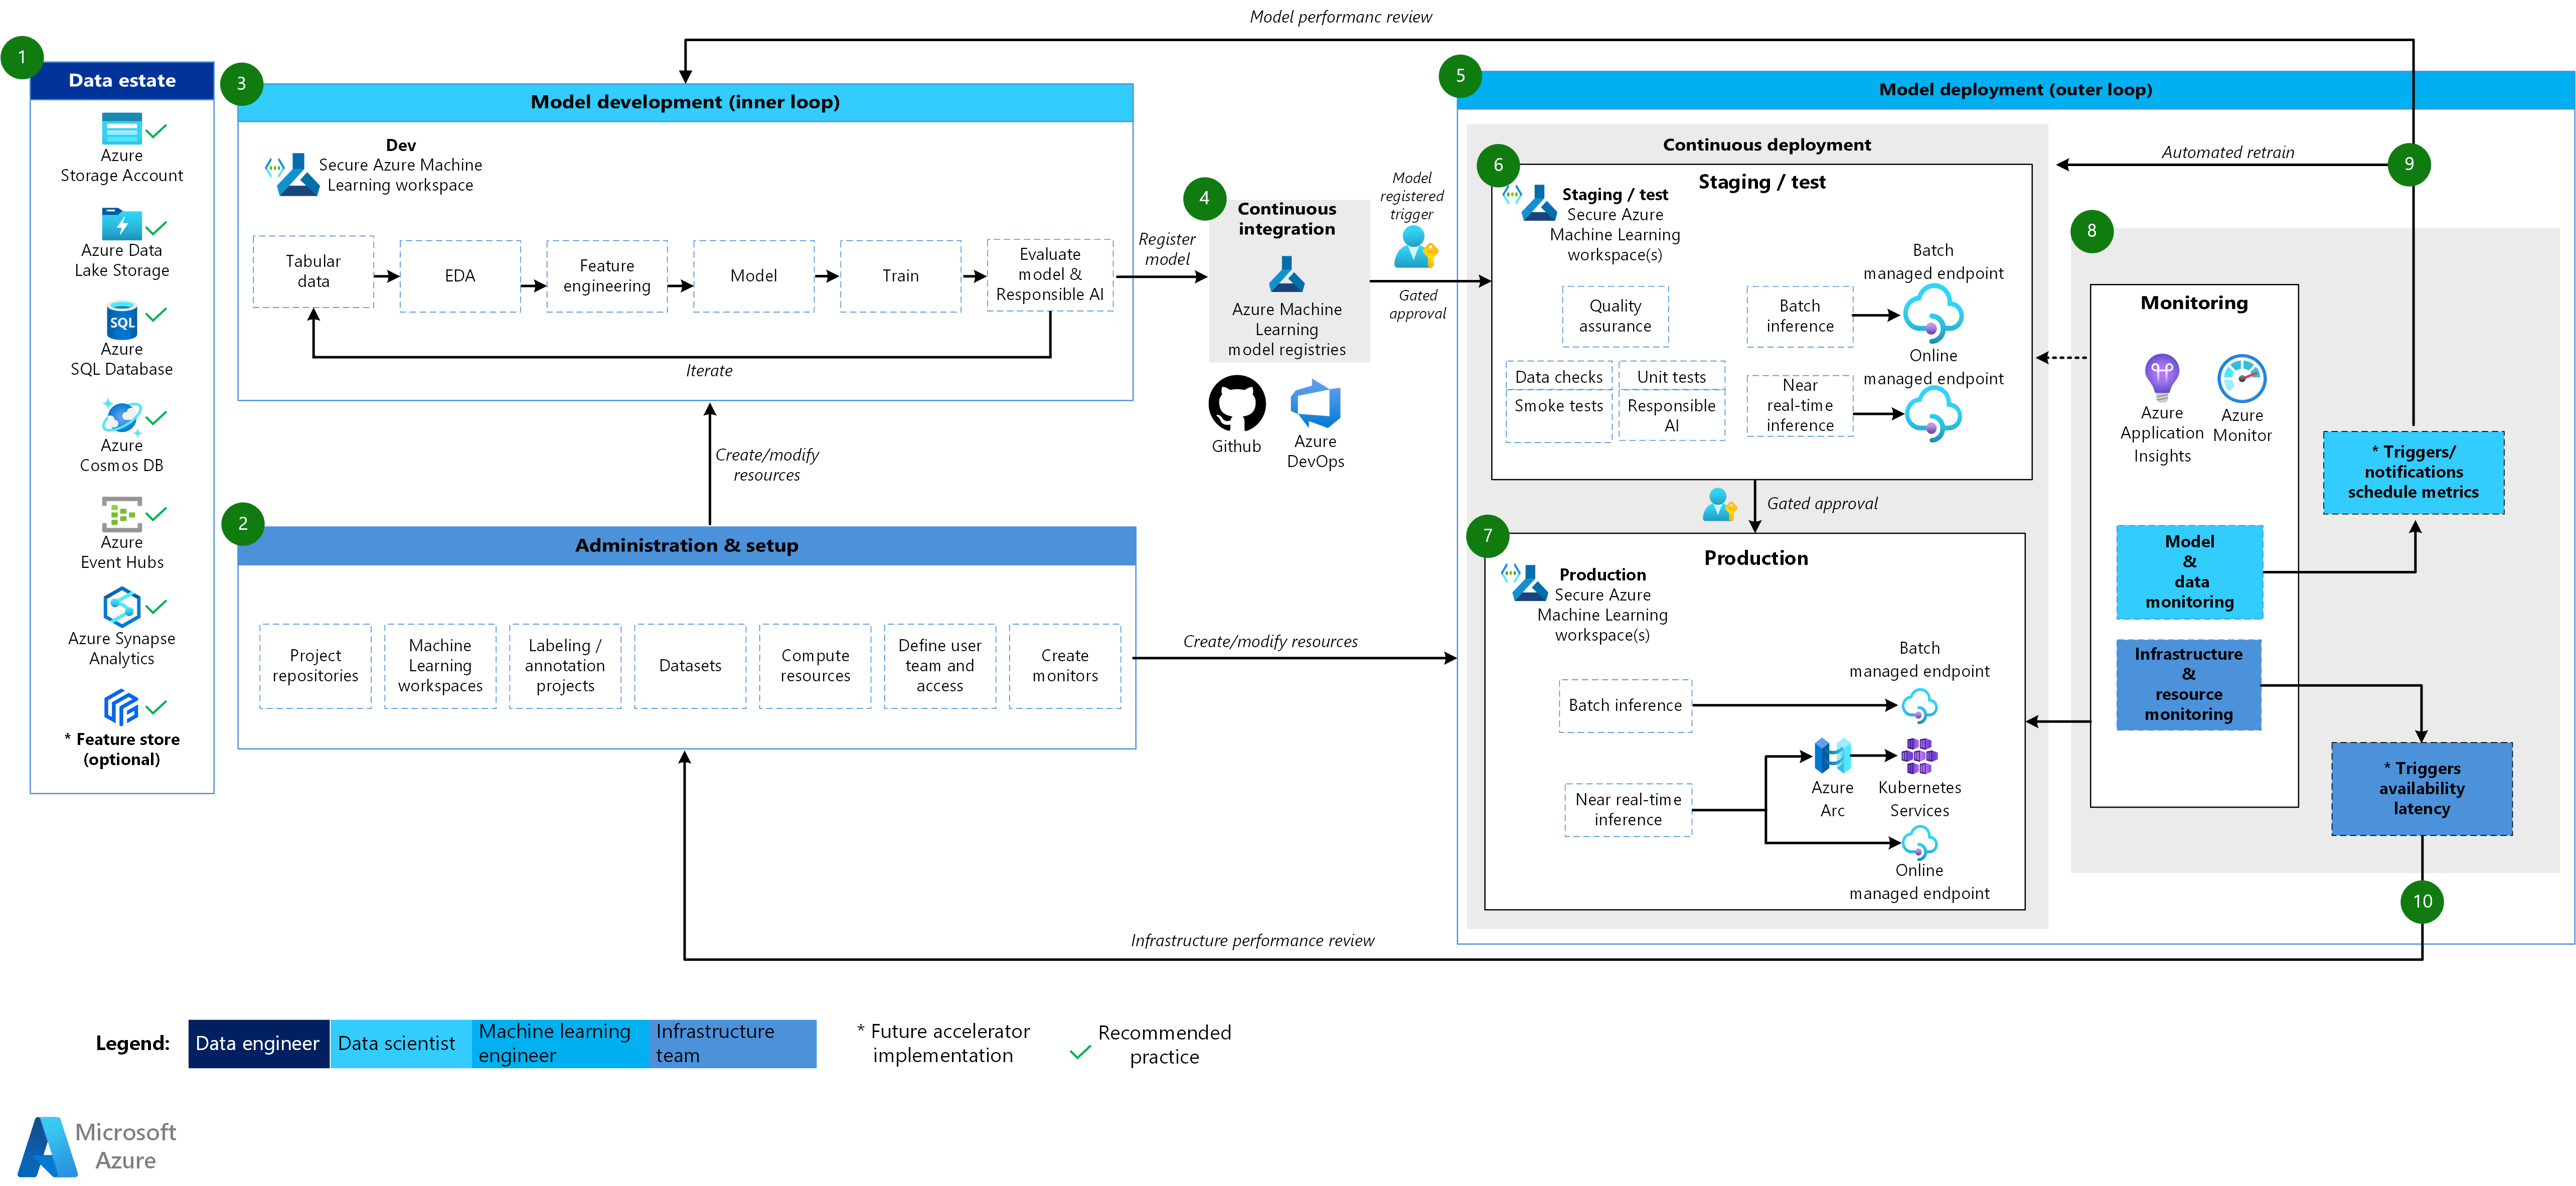


#### Workflow for the classical machine learning architecture
Data estate

This element illustrates the data estate of the organization, and potential data sources and targets for a data science project. Data engineers are the primary owners of this element of the MLOps v2 lifecycle. The Azure data platforms in this diagram are neither exhaustive nor prescriptive. The data sources and targets that represent recommended best practices based on the customer use case are indicated by a green check mark.

Administration and setup

This element is the first step in the MLOps v2 accelerator deployment. It consists of all tasks related to creation and management of resources and roles associated with the project. These can include the following tasks, and perhaps others:

Creation of project source code repositories
Creation of Machine Learning workspaces by using Bicep, ARM, or Terraform
Creation or modification of datasets and compute resources that are used for model development and deployment
Definition of project team users, their roles, and access controls to other resources
Creation of CI/CD pipelines
Creation of monitors for collection and notification of model and infrastructure metrics
The primary persona associated with this phase is the infrastructure team, but there can also be data engineers, machine learning engineers, and data scientists.

Model development (inner loop)

The inner loop element consists of your iterative data science workflow that acts within a dedicated, secure Machine Learning workspace. A typical workflow is illustrated in the diagram. It proceeds from data ingestion, exploratory data analysis, experimentation, model development and evaluation, to registration of a candidate model for production. This modular element as implemented in the MLOps v2 accelerator is agnostic and adaptable to the process your data science team uses to develop models.

Personas associated with this phase include data scientists and machine learning engineers.

Machine Learning registries

After the data science team develops a model that's a candidate for deploying to production, the model can be registered in the Machine Learning workspace registry. CI pipelines that are triggered, either automatically by model registration or by gated human-in-the-loop approval, promote the model and any other model dependencies to the model deployment phase.

Personas associated with this stage are typically machine learning engineers.

Model deployment (outer loop)

The model deployment or outer loop phase consists of pre-production staging and testing, production deployment, and monitoring of model, data, and infrastructure. CD pipelines manage the promotion of the model and related assets through production, monitoring, and potential retraining, as criteria that are appropriate to your organization and use case are satisfied.

Personas associated with this phase are primarily machine learning engineers.

Staging and test

The staging and test phase can vary with customer practices but typically includes operations such as retraining and testing of the model candidate on production data, test deployments for endpoint performance, data quality checks, unit testing, and responsible AI checks for model and data bias. This phase takes place in one or more dedicated, secure Machine Learning workspaces.

Production deployment

After a model passes the staging and test phase, it can be promoted to production by using a human-in-the-loop gated approval. Model deployment options include a managed batch endpoint for batch scenarios or, for online, near-real-time scenarios, either a managed online endpoint or Kubernetes deployment by using Azure Arc. Production typically takes place in one or more dedicated, secure Machine Learning workspaces.

Monitoring

Monitoring in staging, test, and production makes it possible for you to collect metrics for, and act on, changes in performance of the model, data, and infrastructure. Model and data monitoring can include checking for model and data drift, model performance on new data, and responsible AI issues. Infrastructure monitoring can watch for slow endpoint response, inadequate compute capacity, or network problems.

Data and model monitoring: events and actions

Based on criteria for model and data matters of concern such as metric thresholds or schedules, automated triggers and notifications can implement appropriate actions to take. This can be regularly scheduled automated retraining of the model on newer production data and a loopback to staging and test for pre-production evaluation. Or, it can be due to triggers on model or data issues that require a loopback to the model development phase where data scientists can investigate and potentially develop a new model.

Infrastructure monitoring: events and actions

Based on criteria for infrastructure matters of concern such as endpoint response lag or insufficient compute for the deployment, automated triggers and notifications can implement appropriate actions to take. They trigger a loopback to the setup and administration phase where the infrastructure team can investigate and potentially reconfigure the compute and network resources.

## Administration and Security

TBD